In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Загрузка и выбор девайса для обучения

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


Загрузка обучающего, тестового и валидационного датасетов. Для обучающего датасета производится аугментация данных для лучшего обучения

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
train_dataset = datasets.ImageFolder("data/ECOMMERCE_PRODUCT_IMAGES/train", transform=train_transform)
test_dataset = datasets.ImageFolder("data/ECOMMERCE_PRODUCT_IMAGES/check", transform=test_transform)
val_dataset = datasets.ImageFolder("data/ECOMMERCE_PRODUCT_IMAGES/val", transform=test_transform)

In [5]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 13992
    Root location: ECOMMERCE_PRODUCT_IMAGES/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomResizedCrop(size=(128, 128), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# Архитектура модели

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.gap = nn.AdaptiveAvgPool2d((4, 4))
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.dropout = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(512, 9)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

model = Net().to(device)
print(model)

Net(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(

In [9]:
from collections import Counter

### Рассчет весов классов для лучшего обучения

In [10]:
class_counts = Counter(train_dataset.targets)
num_samples = sum(class_counts.values())

class_weights = [num_samples / class_counts[i] for i in range(len(class_counts))]
class_weights = torch.FloatTensor(class_weights).to(device)

In [11]:
import torch.optim as optim

In [12]:
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# optimizer = optim.SGD(model.parameters(), momentum=0.9, weight_decay=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=3
)

In [13]:
import matplotlib.pyplot as plt

# Обучение модели

Epoch [1/50], Loss: 2.1744, Accuracy: 0.2640 Val Acc: 0.3232
Epoch [2/50], Loss: 2.0247, Accuracy: 0.3334 Val Acc: 0.3711
Epoch [3/50], Loss: 1.9488, Accuracy: 0.3679 Val Acc: 0.4001
Epoch [4/50], Loss: 1.8849, Accuracy: 0.3924 Val Acc: 0.4116
Epoch [5/50], Loss: 1.8398, Accuracy: 0.4109 Val Acc: 0.4383
Epoch [6/50], Loss: 1.7765, Accuracy: 0.4320 Val Acc: 0.4681
Epoch [7/50], Loss: 1.7234, Accuracy: 0.4500 Val Acc: 0.4595
Epoch [8/50], Loss: 1.6809, Accuracy: 0.4683 Val Acc: 0.4945
Epoch [9/50], Loss: 1.6316, Accuracy: 0.4879 Val Acc: 0.4901
Epoch [10/50], Loss: 1.5832, Accuracy: 0.5044 Val Acc: 0.5240
Epoch [11/50], Loss: 1.5462, Accuracy: 0.5231 Val Acc: 0.5556
Epoch [12/50], Loss: 1.5067, Accuracy: 0.5363 Val Acc: 0.5366
Epoch [13/50], Loss: 1.4685, Accuracy: 0.5560 Val Acc: 0.5639
Epoch [14/50], Loss: 1.4218, Accuracy: 0.5673 Val Acc: 0.5501
Epoch [15/50], Loss: 1.3750, Accuracy: 0.5853 Val Acc: 0.5719
Epoch [16/50], Loss: 1.3457, Accuracy: 0.5950 Val Acc: 0.5743
Epoch [17/50], Lo

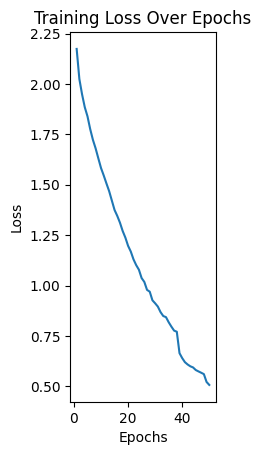

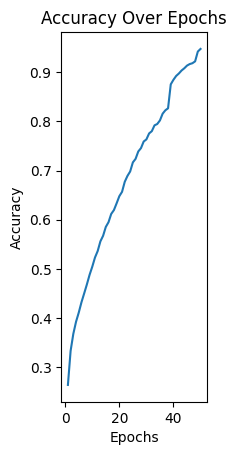

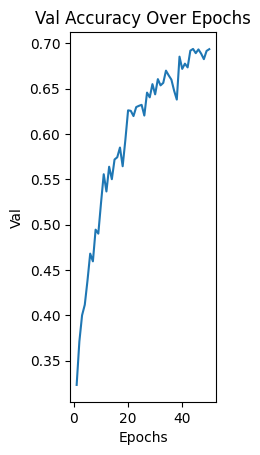

In [14]:
loss_values = []
acc_values = []
val_values = []
epochs = 50

trigger_times = 0
best_val_acc = 0.0
patience = 10

for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    # Обучение и рассчет метрик валидации и обучения
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    avg_loss = running_loss / len(train_loader)
    avg_acc = correct / total
    
    loss_values.append(avg_loss)
    acc_values.append(avg_acc)

    # Валидация модели на текущей эпохе для отслеживания переобучения
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    val_values.append(val_acc)

    scheduler.step(val_acc)
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f} Val Acc: {val_acc:.4f}")

    # Сохранение лучшей итерации обучения модели с остановкой, если валидационные результаты ухудшаются
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        trigger_times = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

plt.subplot(1,3,1)
plt.plot(range(1, epochs+1), loss_values)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.show()

plt.subplot(1,3,2)
plt.plot(range(1, epochs+1), acc_values)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.show()

plt.subplot(1,3,3)
plt.plot(range(1, epochs+1), val_values)
plt.xlabel("Epochs")
plt.ylabel("Val")
plt.title("Val Accuracy Over Epochs")
plt.show()

Данная модель достигла неплохих результатов, но валидационные показатели не возрасли выше 0.69, что говорит о том, что модель плохо справлялась с обобщением и заучивала тестовые результаты (тестовые метрики растут, а валидационные вышли на плато). Вероятно, присустсвует переобучение модели, но я не смог с ним справиться без ухудшения метрик 

# Валидация 

In [15]:
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)  
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on test set: {accuracy:.2f}%")

Accuracy on test set: 70.24%


## Confusion matrix

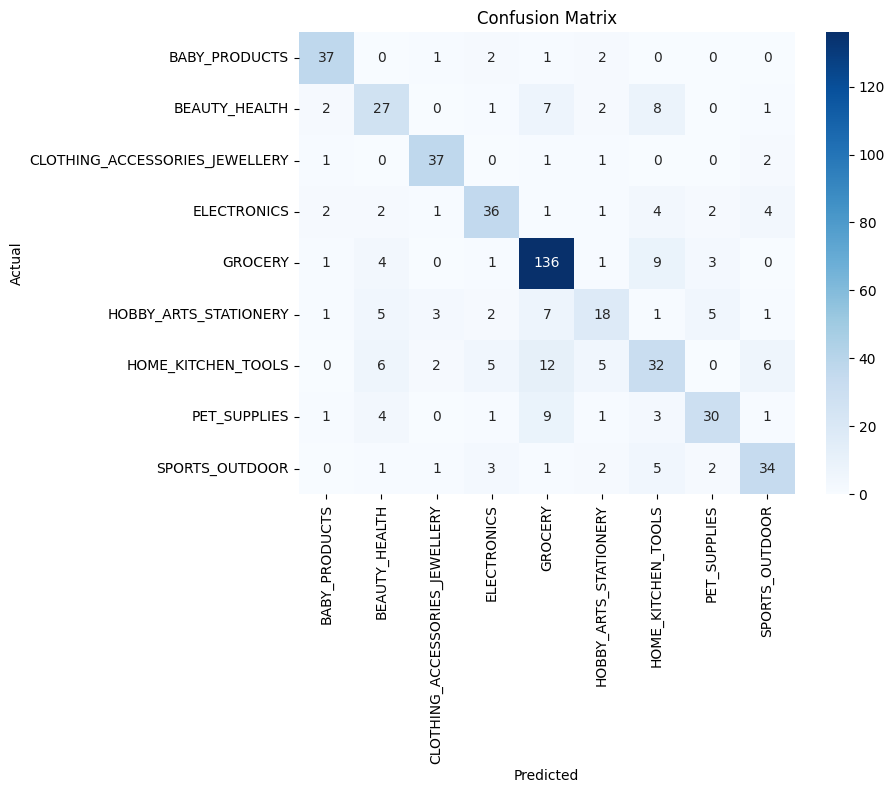


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        43
           1       0.55      0.56      0.56        48
           2       0.82      0.88      0.85        42
           3       0.71      0.68      0.69        53
           4       0.78      0.88      0.82       155
           5       0.55      0.42      0.47        43
           6       0.52      0.47      0.49        68
           7       0.71      0.60      0.65        50
           8       0.69      0.69      0.69        49

    accuracy                           0.70       551
   macro avg       0.68      0.67      0.68       551
weighted avg       0.69      0.70      0.70       551



In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

## Сохранение модели

In [19]:
torch.save({
    "model_state_dict": model.state_dict(),
    "classes": train_dataset.classes
}, "models/image_model.pth")